In [9]:
from __future__ import division
#locations, locations
#Georgi's CISBP list grepped for SPI1:
spi1_cisbp_hits = "/home/ktian/kundajelab/tfnet/results/nandi/CIS-BP/data/SPI1.txt"
#1kb around SPI1 GM12878 summits:
spi1_summits_and_flank_coords = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.tsv"
spi1_summits_and_flank_fa = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.fa"
hyp_scores = "/home/ktian/kundajelab/tfnet/results/nandi/SPI1/SPI1_GM12878_refine_18_09_04/scores/hyp_scores_task_0.npy"
spi1_bqtls = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/SPI1.txt"

In [202]:
import numpy as np
pwm_name_to_matrix = {
    "M4475_1.02": np.array([
[0.347561,0.211382,0.27439,0.166667],
[0.504065,0.083333,0.304878,0.107724],
[0.727642727642728,0.0426830426830427,0.0833330833330833,0.146341146341146],
[0.735772735772736,0.0284550284550285,0.121951121951122,0.113821113821114],
[0.674797,0.00813,0.081301,0.235772],
[0.113821,0.04878,0.823171,0.014228],
[0.636179,0.073171,0.29065,0.0],
[0.087398,0.0,0.912602,0.0],
[0.002033,0.0,0.997967,0.0],
[1.0,0.0,0.0,0.0],
[0.987804012195988,0.00203299796700203,0.0,0.0101629898370102],
[0.020325,0.325203,0.654472,0.0],
[0.026423,0.0,0.004065,0.969512],
[0.004065,0.018293,0.977642,0.0],
[0.689024,0.069106,0.21748,0.02439],
[0.514228,0.073171,0.313008,0.099593],
[0.729675,0.105691,0.083333,0.081301],
[0.231707,0.367886,0.268293,0.132114],
[0.245935245935246,0.274390274390274,0.142276142276142,0.337398337398337]])}

In [108]:
from collections import defaultdict

##filter the SPI1 bQTLs for the ones that are in the 1kb summits
spi1_bqtls_in_1kb = "spi1_bqtls_in_1kb.txt"
! ./filter_bqtls_to_be_in_region.sh $spi1_bqtls $spi1_summits_and_flank_coords > $spi1_bqtls_in_1kb

In [ ]:
from collections import defaultdict, namedtuple
import numpy as np

#read in all the region coordinates and create a map from coordinate to index
region_coord_to_idx = {}
for i,line in enumerate(open(spi1_summits_and_flank_coords)):
    chrom,start,end = line.rstrip().split("\t")
    region_coord_to_idx[chrom+":"+start+"-"+end] = i
total_regions = max(coord_to_idx.values())+1

BQTL = namedtuple("BQTL", ["chrom", "chrom_start", "region_idx", "offset", "alt_allele", "post_allele", "pval"])
    
region_idx_to_bqtls = defaultdict(list)
all_bqtls = []
    
#read in all the bqtl info, get the bQTL coordinates relative to the region starts
for line in open(spi1_bqtls_in_1kb):
    bqtl_chrom,bqtl_start,bqtl_end,alt_allele,post_allele,pval,region_chrom,region_start,region_end = line.rstrip().split("\t")
    bqtl_start = int(bqtl_start)
    bqtl_end = int(bqtl_end)
    pval = float(pval)
    region_idx = region_coord_to_idx[region_chrom+":"+region_start+"-"+region_end]
    region_start = int(region_start)
    region_end = int(region_end)    
    offset_from_start = bqtl_start-region_start
    assert bqtl_chrom==region_chrom
    assert offset_from_start >= 0 and offset_from_start <= 1000
    bqtl = BQTL(chrom=bqtl_chrom, chrom_start=bqtl_start,
                region_idx=region_idx, offset=offset_from_start,
                alt_allele=alt_allele, post_allele=post_allele, pval=pval)
    all_bqtls.append(bqtl)
    region_idx_to_bqtls[region_idx].append(bqtl)

In [ ]:
#read in the hyp contribs
hypcontribs = np.load(hyp_scores)
assert len(hypcontribs)==total_regions

In [ ]:

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the DNA sequence at these regions, one-hot encode
fasta_sequences = []
for i,a_line in enumerate(open(spi1_summits_and_flank_fa)):
    if (i%2 == 1):
        a_line = a_line.rstrip()
        fasta_sequences.append(a_line)
onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                        for seq in fasta_sequences])
print(onehot_data.shape)

#compute the background ACGT frequency
acgt_freqs = np.mean(onehot_data, axis=(0,1))
print(acgt_freqs)

In [288]:
from scipy.signal import correlate2d
import sys

pwm_scores = {}
#scan all the sequences using the PWMs (pad the ends as needed)
print("Scanning with pwms")
sys.stdout.flush()
for pwm_name in pwm_name_to_matrix:
    log_odds_pwm = np.log(pwm_name_to_matrix[pwm_name]/acgt_freqs[None,:] + 0.0000001)
    pwm_scores[pwm_name] = np.pad(np.squeeze(np.array([
                                    np.maximum(correlate2d(in1=x,in2=log_odds_pwm,mode="valid"),
                                               correlate2d(in1=x,in2=log_odds_pwm[::-1,::-1],mode="valid"))
                                              for x in onehot_data])),
                                  pad_width=[(0,0), (int((len(log_odds_pwm)-1)/2),
                                                     (len(log_odds_pwm)-1)-int((len(log_odds_pwm)-1)/2))],
                                  mode='constant')

print(pwm_scores['M4475_1.02'].shape)

Scanning with pwms
(38932, 1000)


In [289]:
#get the hyp contrib predicted delta
bqtl_hypcontrib_delta = []
bqtl_position_max_delta = []
bqtl_nearby_importance = []
bqtl_neglog10_pvalues = []
bqtl_pwm_scores = defaultdict(list)
letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
half_window_size = 20
for bqtl in all_bqtls:
    #if (abs(bqtl.offset - 500) > 200):
    alt_letter_idx = letter_to_idx[bqtl.alt_allele]
    post_letter_idx = letter_to_idx[bqtl.post_allele]
    assert onehot_data[bqtl.region_idx, bqtl.offset, post_letter_idx]==1
    
    bqtl_hypcontrib_delta.append(hypcontribs[bqtl.region_idx, bqtl.offset, post_letter_idx]
                                 - hypcontribs[bqtl.region_idx, bqtl.offset, alt_letter_idx])
    bqtl_position_max_delta.append(np.max(hypcontribs[bqtl.region_idx, bqtl.offset])
                                   - np.min(hypcontribs[bqtl.region_idx, bqtl.offset]))
    bqtl_nearby_importance.append(np.sum(np.abs(hypcontribs[bqtl.region_idx,
                                                            max(bqtl.offset-half_window_size,0):
                                                            (bqtl.offset+half_window_size)])))
    bqtl_neglog10_pvalues.append(-np.log(bqtl.pval)/np.log(10))

    #max pwm scores within half_window_sizebp on either side
    for pwm_name in pwm_scores:
        bqtl_pwm_scores[pwm_name].append(np.max(pwm_scores[pwm_name][bqtl.region_idx,
                                                                 max(bqtl.offset-half_window_size,0):
                                                                 (bqtl.offset+half_window_size)])) 
    
bqtl_hypcontrib_delta = np.array(bqtl_hypcontrib_delta)
bqtl_position_max_delta = np.array(bqtl_position_max_delta)
bqtl_nearby_importance = np.array(bqtl_nearby_importance)
bqtl_neglog10_pvalues = np.array(bqtl_neglog10_pvalues)
bqtl_pwm_scores = dict([(x,np.array(y)) for x,y in bqtl_pwm_scores.items()])

In [290]:
def percentile_normalize(vals):
    sorted_vals = sorted(enumerate(vals), key=lambda x: x[1])
    original_ordering = [x[0] for x in sorted_vals]
    sorted_val_percentiles = np.arange(len(sorted_vals))/len(sorted_vals)
    return np.array([x[0] for x in sorted(zip(sorted_val_percentiles,original_ordering), key=lambda x: x[1])])

percnormed_bqtl_hypcontrib_delta = percentile_normalize(np.abs(bqtl_hypcontrib_delta))
percnormed_bqtl_nearby_importance = percentile_normalize(bqtl_nearby_importance)
percnormed_bqtl_neglog10_pvalues = percentile_normalize(bqtl_neglog10_pvalues)
percnormed_prod_hypcontrib_nearbyimp_percentile = percentile_normalize(percnormed_bqtl_nearby_importance
                                                                       *percnormed_bqtl_hypcontrib_delta)
percnormed_bqtl_pwm_scores = dict([(pwm_name, percentile_normalize(bqtl_pwm_scores[pwm_name]))
                              for pwm_name in bqtl_pwm_scores])

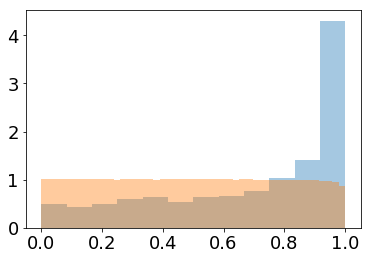

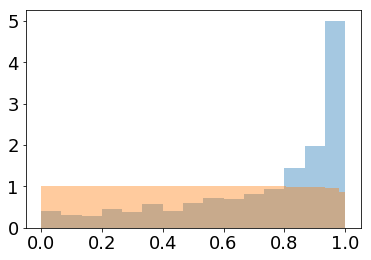

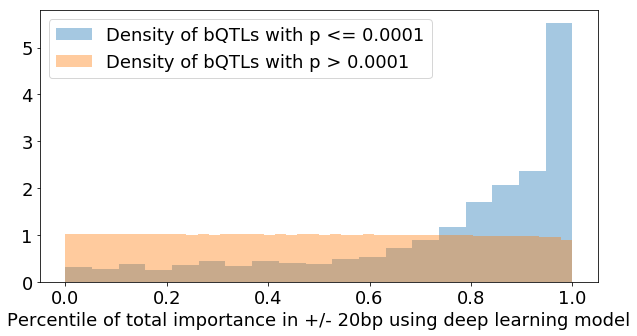

M4475_1.02


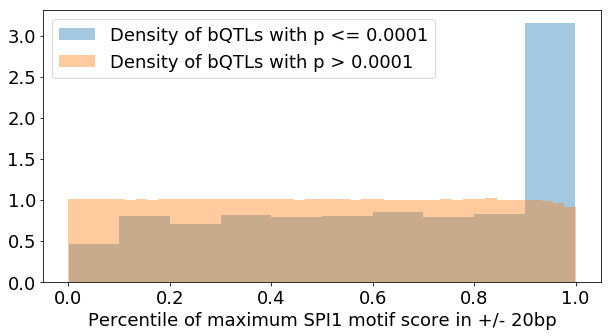

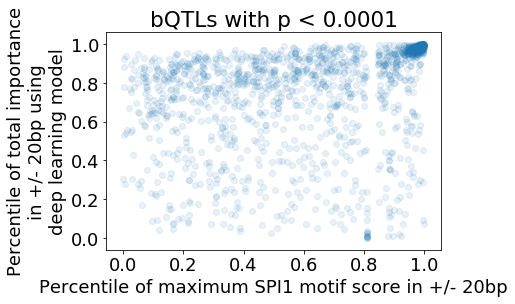

In [291]:
import seaborn as sns
#plt.hist(percnormed_min_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues > 4], bins=100)
#plt.show()

import matplotlib

font = {'size'   : 18}
matplotlib.rc('font', **font)

#sns.distplot(percnormed_bqtl_hypcontrib_delta[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True)
#sns.distplot(percnormed_bqtl_hypcontrib_delta[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True)
#plt.show()

#sns.distplot(percnormed_prod_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True)
#sns.distplot(percnormed_prod_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True)
#plt.show()

handles = []
plt.figure(figsize=(10,5))
handles.append(sns.distplot(percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
handles.append(sns.distplot(percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
plt.xlabel("Percentile of total importance in +/- 20bp using deep learning model")
plt.show()

#handles = []
#plt.figure(figsize=(10,5))
#handles.append(sns.distplot(bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
#handles.append(sns.distplot(bqtl_nearby_importance[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
#plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
#plt.xlabel("Total importance in +/- 20bp using deep learning model")
#plt.show()

for pwm_name in percnormed_pwm_scores:
    print(pwm_name)
    handles = []
    plt.figure(figsize=(10,5))
    handles.append(sns.distplot(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
    handles.append(sns.distplot(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
    plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
    plt.xlabel("Percentile of maximum SPI1 motif score in +/- 20bp")
    plt.show()
    
    
    
    plt.scatter(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4],
                percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], alpha=0.1)
    plt.title("bQTLs with p < 0.0001")
    plt.xlabel("Percentile of maximum SPI1 motif score in +/- 20bp")
    plt.ylabel("Percentile of total importance\nin +/- 20bp using\ndeep learning model")
    
    #handles = []
    #plt.figure(figsize=(10,5))
    #handles.append(sns.distplot(bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
    #handles.append(sns.distplot(bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
    #plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
    #plt.xlabel("Maximum SPI1 motif score in +/- 20bp")
    #plt.show()

The PWM


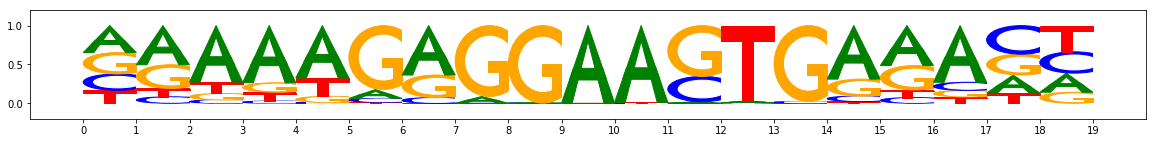

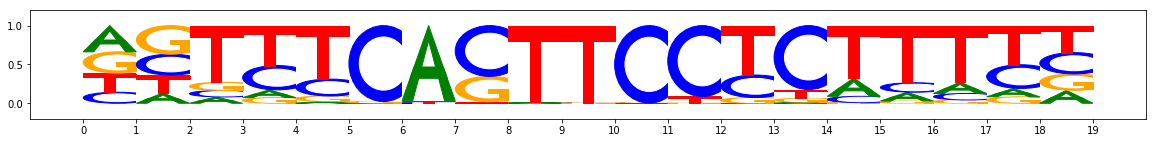

BQTL(chrom='chr3', chrom_start=121984020, region_idx=23535, offset=486, alt_allele='A', post_allele='G', pval=3.04205012005437e-07)


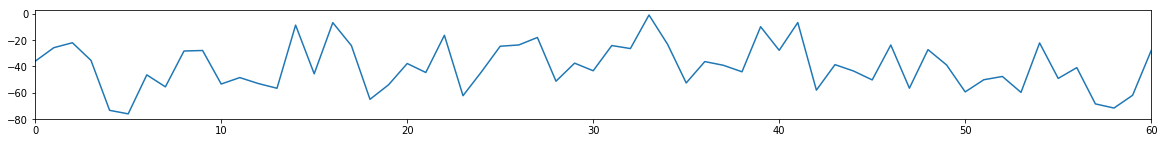

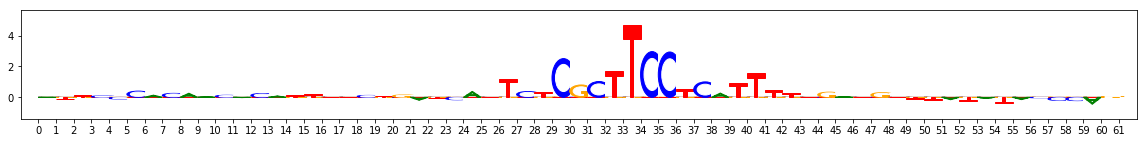

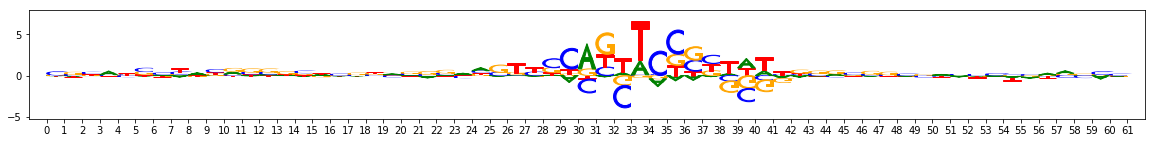

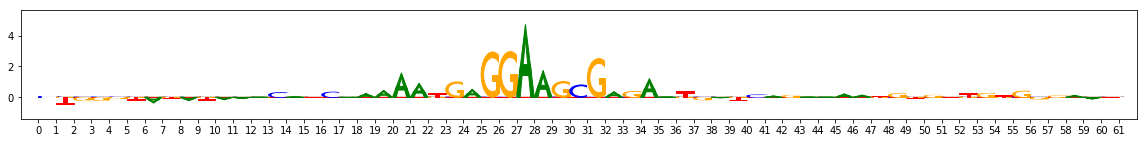

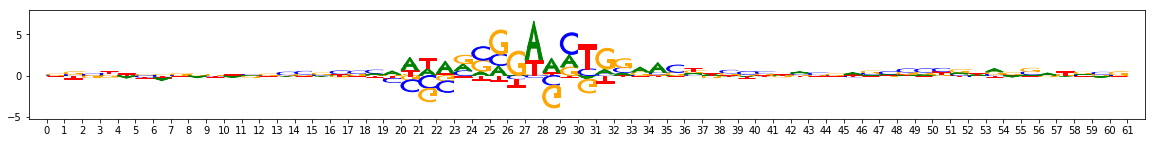

BQTL(chrom='chr13', chrom_start=101457533, region_idx=7468, offset=491, alt_allele='C', post_allele='A', pval=9.1052030929498e-05)


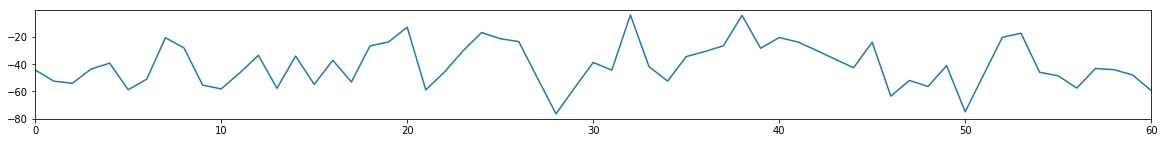

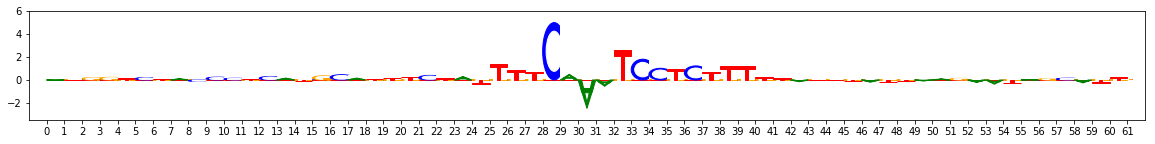

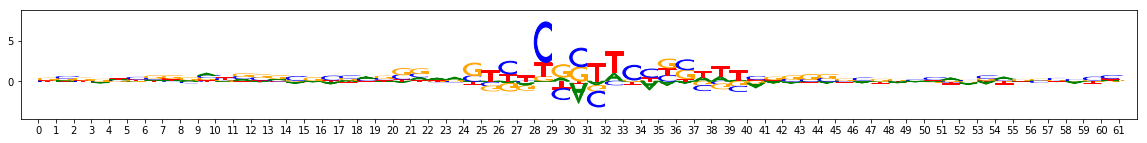

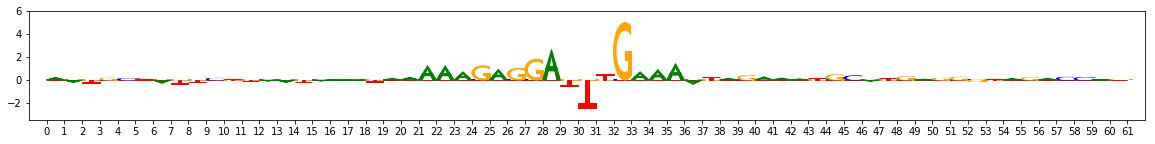

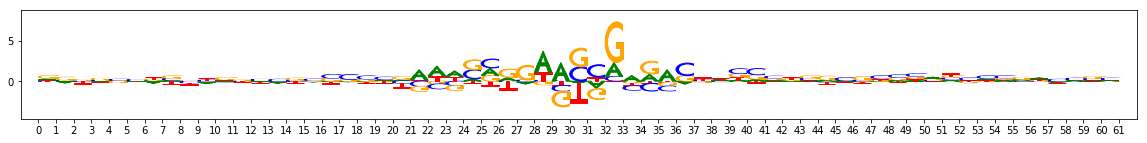

BQTL(chrom='chr6', chrom_start=37651562, region_idx=30172, offset=491, alt_allele='A', post_allele='G', pval=2.2542118013757e-08)


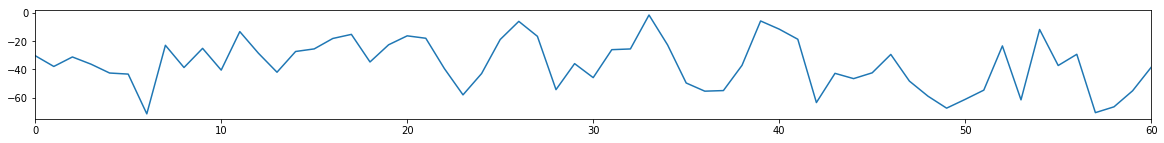

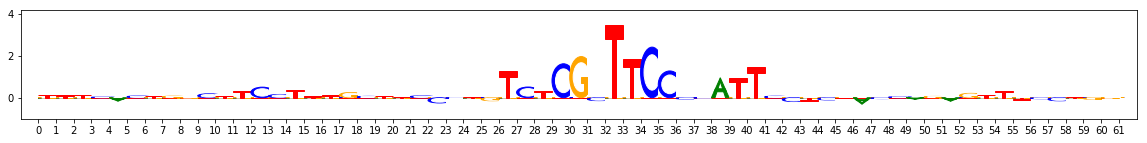

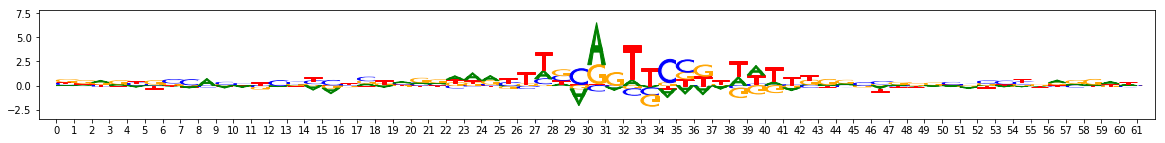

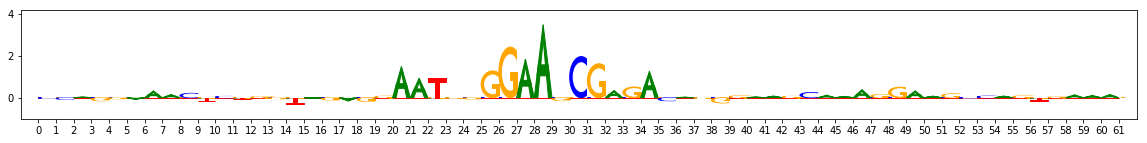

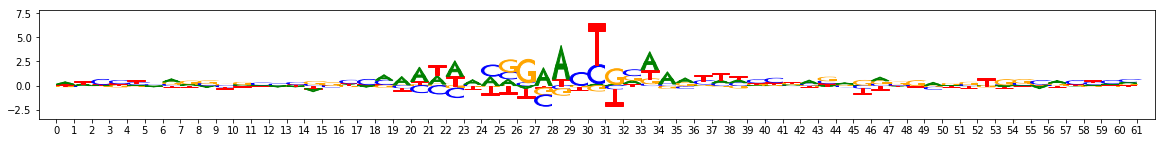

BQTL(chrom='chr2', chrom_start=182035191, region_idx=18447, offset=482, alt_allele='A', post_allele='T', pval=6.22829209485468e-07)


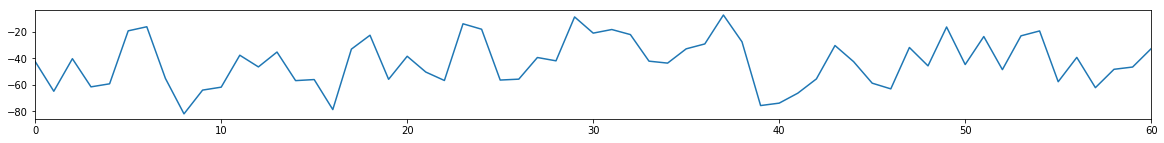

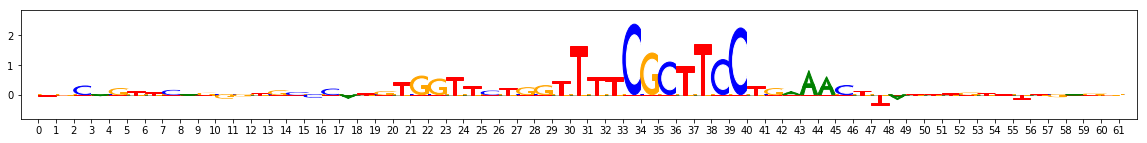

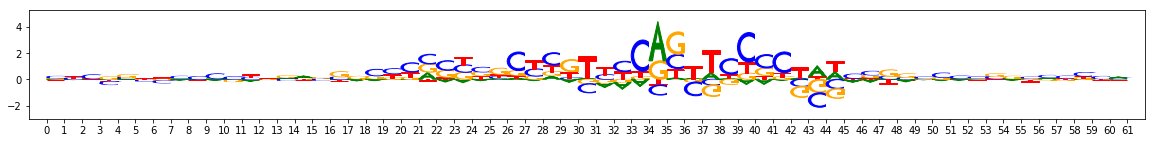

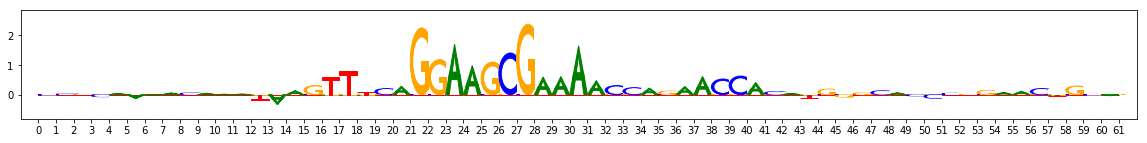

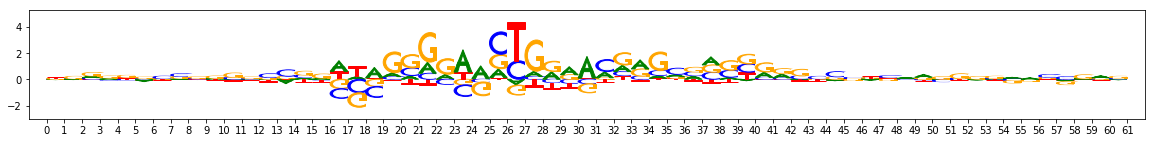

BQTL(chrom='chr4', chrom_start=41649553, region_idx=25227, offset=485, alt_allele='A', post_allele='G', pval=6.95390200162978e-38)


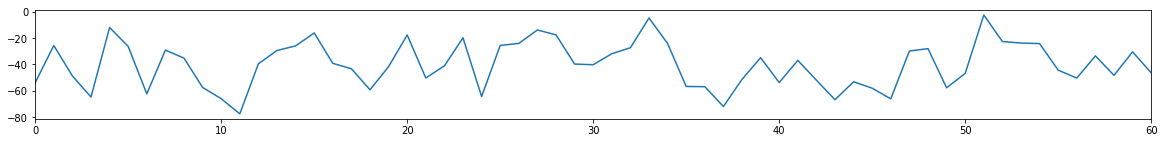

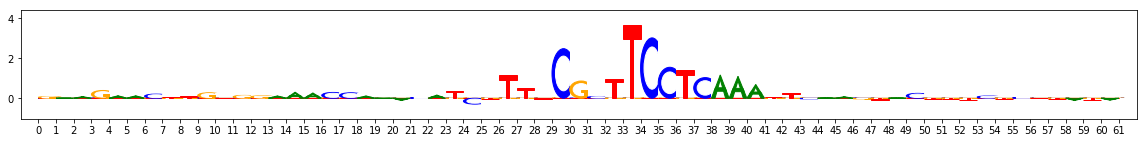

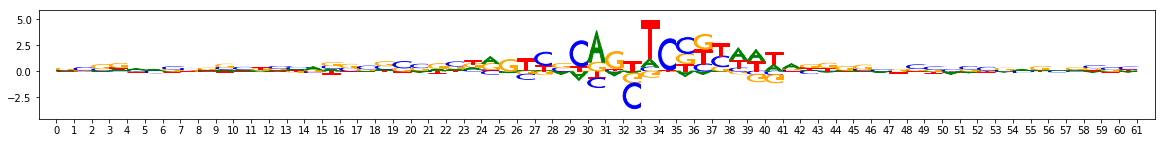

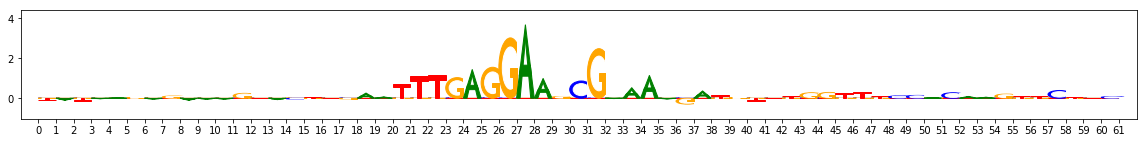

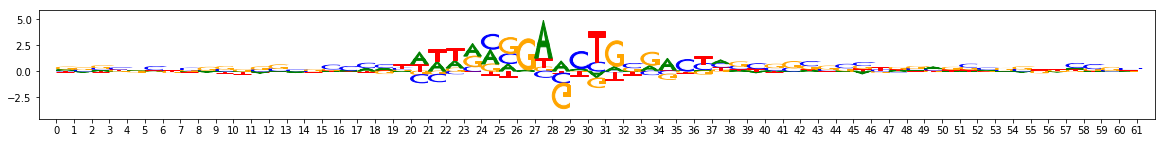

BQTL(chrom='chr6', chrom_start=2854366, region_idx=29208, offset=489, alt_allele='A', post_allele='G', pval=5.58539895942768e-29)


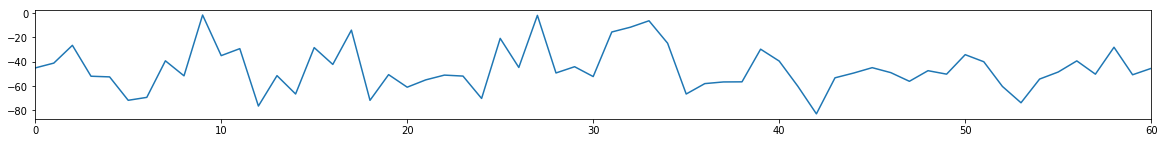

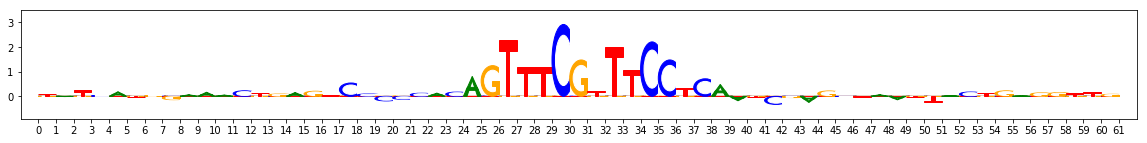

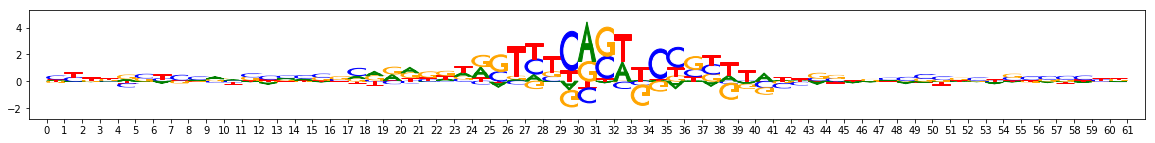

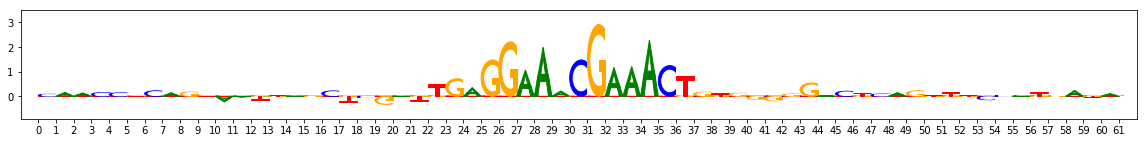

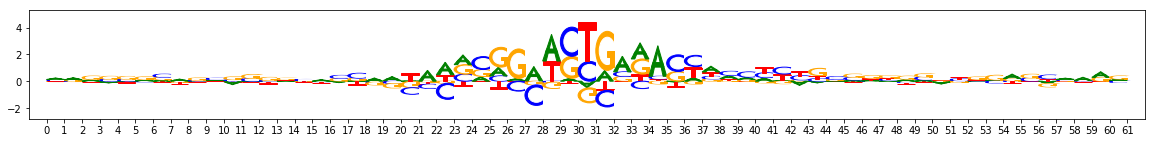

BQTL(chrom='chr15', chrom_start=40408210, region_idx=9192, offset=513, alt_allele='A', post_allele='G', pval=1.25842590278299e-05)


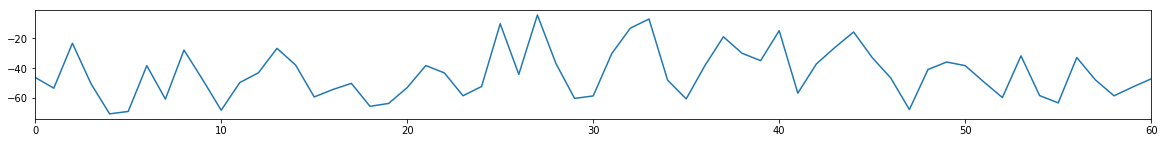

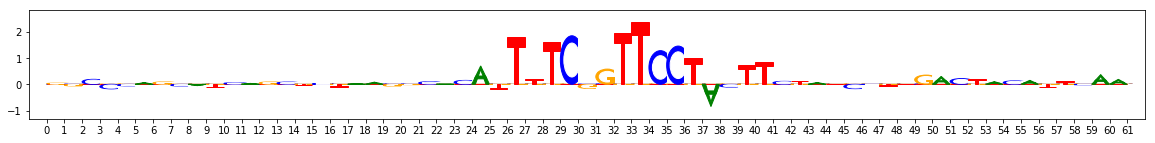

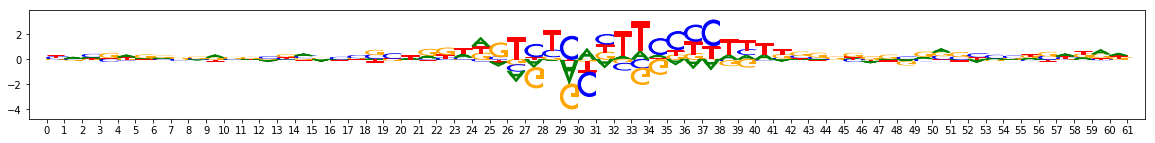

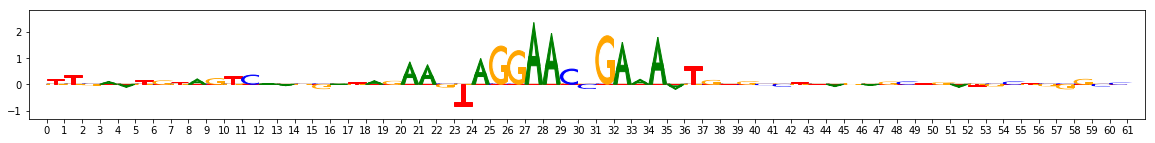

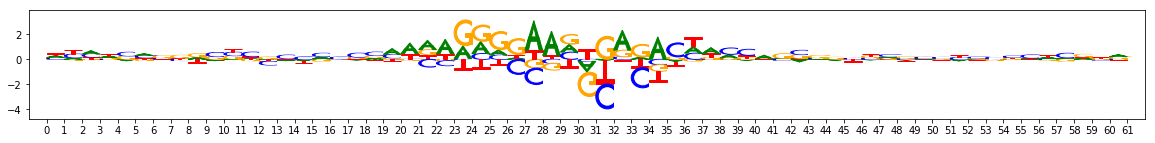

BQTL(chrom='chr2', chrom_start=17342056, region_idx=16075, offset=505, alt_allele='T', post_allele='C', pval=2.2315147385939e-10)


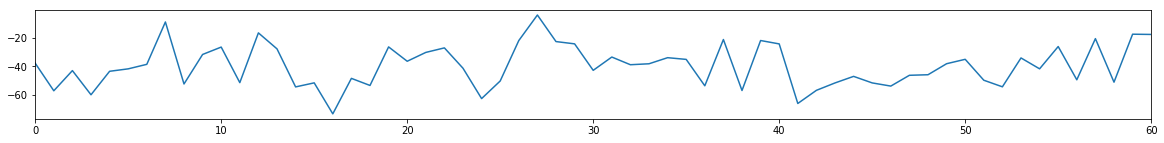

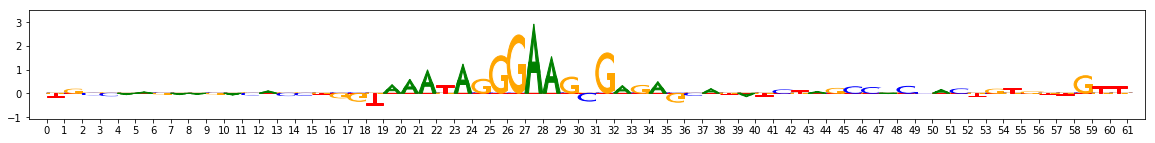

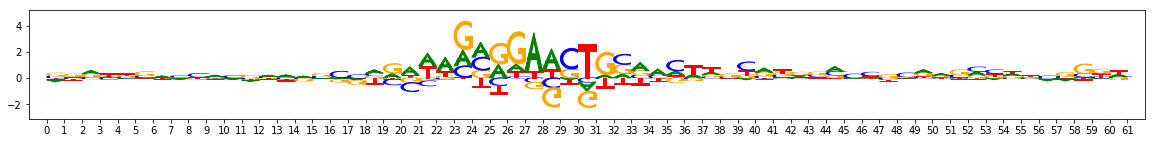

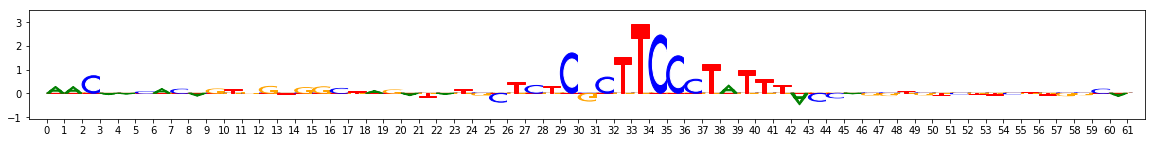

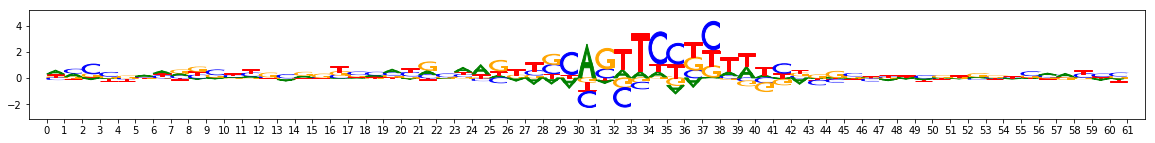

BQTL(chrom='chr3', chrom_start=195868505, region_idx=24632, offset=500, alt_allele='A', post_allele='G', pval=4.58399597362991e-09)


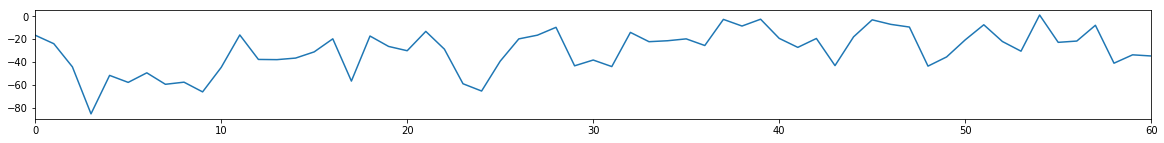

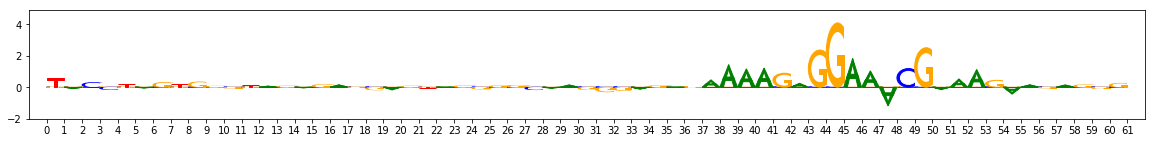

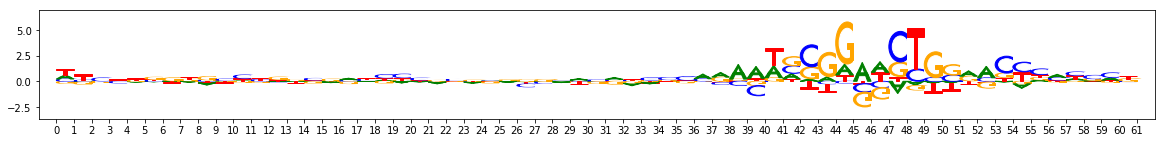

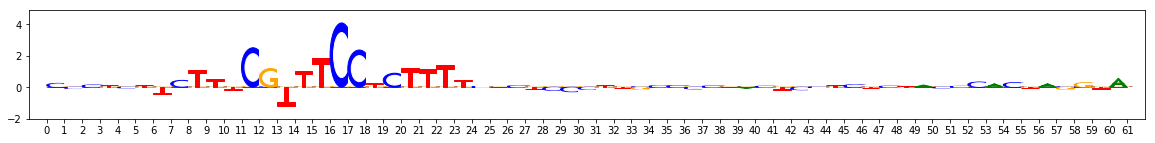

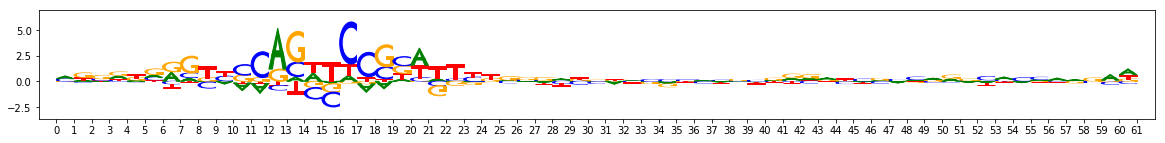

BQTL(chrom='chr4', chrom_start=81973458, region_idx=25570, offset=474, alt_allele='C', post_allele='A', pval=3.67404645026843e-05)


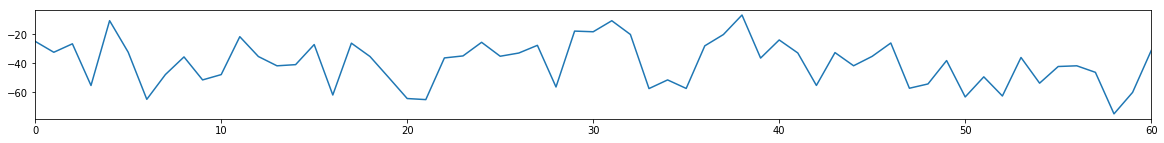

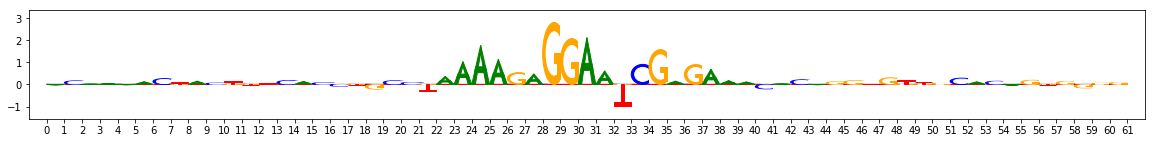

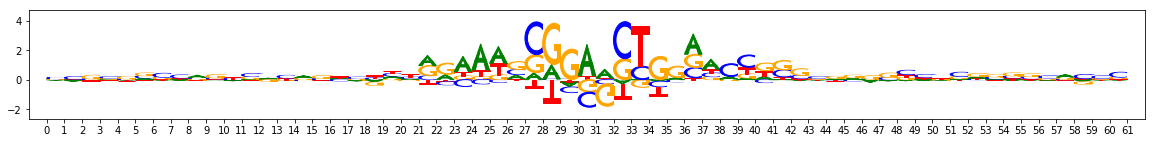

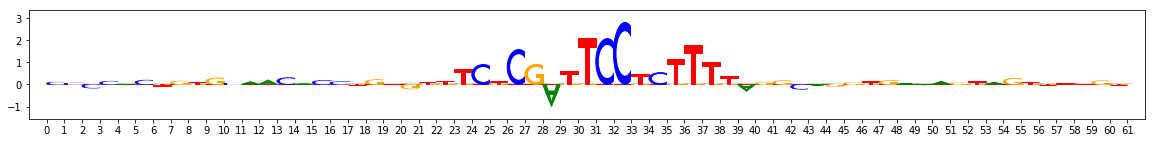

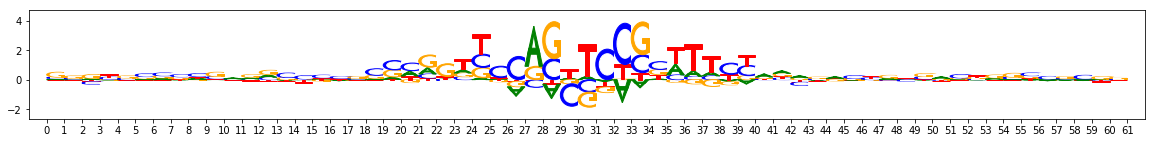

BQTL(chrom='chr4', chrom_start=82342736, region_idx=25573, offset=503, alt_allele='A', post_allele='G', pval=7.56327430293999e-05)


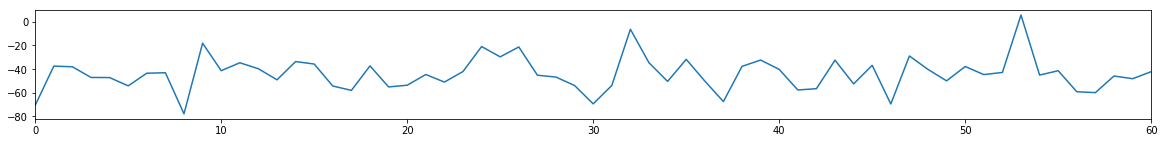

In [ ]:
from deeplift.visualization import viz_sequence
import sys

font = {'size'   : 10}
matplotlib.rc('font', **font)

pwm_name = 'M4475_1.02'
print("The PWM")
viz_sequence.plot_weights(pwm_name_to_matrix[pwm_name])
viz_sequence.plot_weights(pwm_name_to_matrix[pwm_name][::-1,::-1])

idxs_missed_by_motifs = sorted(np.nonzero((percnormed_bqtl_pwm_scores[pwm_name] < 0.8) * (bqtl_neglog10_pvalues >= 4))[0],
                               key=lambda x: -percnormed_bqtl_nearby_importance[x])


for idx in idxs_missed_by_motifs[:20]:
    bqtl = all_bqtls[idx]
    print(bqtl)
    post_letter_idx = letter_to_idx[bqtl.post_allele]
    plt.figure(figsize=(20,2))
    plt.plot(pwm_scores[pwm_name][bqtl.region_idx,bqtl.offset-30:bqtl.offset+31])
    plt.xlim((0,60))
    plt.show()
    viz_sequence.plot_weights((onehot_data[bqtl.region_idx]*hypcontribs[bqtl.region_idx])[bqtl.offset-30:bqtl.offset+31])
    viz_sequence.plot_weights(hypcontribs[bqtl.region_idx][bqtl.offset-30:bqtl.offset+31])
    viz_sequence.plot_weights((onehot_data[bqtl.region_idx]*hypcontribs[bqtl.region_idx])[bqtl.offset-30:bqtl.offset+31][::-1,::-1])
    viz_sequence.plot_weights(hypcontribs[bqtl.region_idx][bqtl.offset-30:bqtl.offset+31][::-1,::-1])
    
